In [1]:
import wrangle
import viz
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import skim
from scipy import stats

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

#from sklearn.compose import TransformedTargetRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data from a local csv originally obtained from:
#    https://www.kaggle.com/code/desalegngeb/auctioning-used-cars-what-matters-most/data?select=car_prices.csv

df = pd.read_csv('car_prices.csv', error_bad_lines=False, warn_bad_lines=False)

In [3]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 558811 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 16     │ │ int64       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA      ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75     ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ year             │       0 │       0 │    2000 │       4 │   2000 │    2000 │    2000 │      2000 │    ▁▃█ │  │
│ │ condition        │   12000 │     2.1 │     3.4 │    0.95 │      1 │     2.7 │     4.2 │         5 │  ▄▅▆█▅ │  │
│ │ odometer         │      94 │   0.017 │   68000 │   53000 │      1 │   28000 │   99000 │   1000000 │   █    │  │
│ │ mmr              │       0 │       0 │   14000 │    9700 │     25 │    7100 │   18000 │    180000 │   █    │  │
│ │ sellingprice     │       0 │       0 │   14000 │    9700 │      1 │    6900 │   18000 │    230000 │   █    │  │
│ └──────────────────┴─────────┴─────────┴─────────┴─────────┴────────┴─────────┴─────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │        10000 │        1.8 │                       0.98 │                550000 │  │
│ │ model                     │        10000 │        1.9 │                       0.98 │                550000 │  │
│ │ trim                      │        11000 │        1.9 │                       0.98 │                550000 │  │
│ │ body                      │        13000 │        2.4 │                       0.98 │                550000 │  │
│ │ transmission              │        65000 │         12 │                       0.98 │                550000 │  │
│ │ vin                       │            0 │          0 │                       0.98 │                550000 │  │
│ │ state                     │            0 │          0 │                       0.98 │                550000 │  │
│ │ color                     │          750 │       0.13 │                       0.98 │                550000 │  │
│ │ interior                  │          750 │       0.13 │                       0.98 │                550000 │  │
│ │ seller                    │            0 │          0 │                       0.98 │                550000 │  │
│ │ saledate                  │            0 │          0 │                       0.98 │                550000 │  │
│ └───────────────────────────┴──────────────┴──────────

Most of the null values (12% of the dataframe) is in the transmission column

In [4]:
df.transmission.value_counts()

automatic    475914
manual        17544
Name: transmission, dtype: Int64

Convert transmission nulls to 'unknown', remaining rows with null will be dropped.

In [5]:
df.make.value_counts()

Ford          93554
Chevrolet     60197
Nissan        53946
Toyota        39871
Dodge         30710
              ...  
airstream         1
ford tk           1
chev truck        1
hyundai tk        1
Lotus             1
Name: make, Length: 96, dtype: Int64

'Ford' vs 'ford' vs 'ford tk' 

        - Will need to filter and convert using string manipulation
        - Several makes with low number of observations (Lotus, Delorian, etc.) that will be filtered out
            - Similiar operations performed on State, Color, Interior, etc to be handled in the same way

In [6]:
df.vin.value_counts()

wbanv13588cz57827    5
wp0ca2988xu629622    4
5n1ar1nn2bc632869    4
wddgf56x78f009940    4
trusc28n241022003    4
                    ..
5gtdn136968177965    1
1lnhm82v36y610348    1
wmwre33546tj33043    1
salae254x6a381803    1
1ftfw1et2eke87277    1
Name: vin, Length: 550296, dtype: Int64

Repeat VINs would indicate multiple sales.  This occurs less than 1% of the time, so will drop all instances where duplicates occur

In [7]:
df.color.value_counts().head(9)

black     110970
white     106673
silver     83389
gray       82857
blue       51139
red        43569
—          24685
green      11382
gold       11342
Name: color, dtype: Int64

Color and interior had columns with dashes.  Convert these to 'unknown'

In [8]:
print('Range of Selling Price is: ',end='')
print("${:.2f}".format(df.sellingprice.min()),end=' - ')
print("${:.2f}".format(df.sellingprice.max()))

Range of Selling Price is: $1.00 - $230000.00


I don't want salvage sales or exotics, but we do want a wide range, so I'll filter the outliers that are more than 3 std deviations from the interquartile range

In [9]:
df = wrangle.carwash_1(df)

In [10]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 513951 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 16     │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0     ┃ p25     ┃ p75     ┃ p100       ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩  │
│ │ year              │    0 │      0 │     2000 │     3.8 │   2000 │    2000 │    2000 │       2000 │   ▁▂▂█  │  │
│ │ condition         │    0 │      0 │      3.4 │    0.95 │      1 │     2.7 │     4.2 │          5 │  ▄▄▅█▅  │  │
│ │ odometer          │    0 │      0 │    66000 │   52000 │      1 │   28000 │   96000 │    1000000 │    █    │  │
│ │ mmr               │    0 │      0 │    14000 │    8700 │     25 │    7500 │   18000 │     110000 │   █▂    │  │
│ │ sellingprice      │    0 │      0 │    14000 │    8800 │      1 │    7300 │   18000 │      52000 │  ▆█▄▁   │  │
│ └───────────────────┴──────┴────────┴──────────┴─────────┴────────┴─────────┴─────────┴────────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA     ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                       │      0 │          0 │                            1 │                   520000 │  │
│ │ model                      │      0 │          0 │                            1 │                   520000 │  │
│ │ trim                       │      0 │          0 │                            1 │                   520000 │  │
│ │ body                       │      0 │          0 │                            1 │                   520000 │  │
│ │ transmission               │      0 │          0 │                            1 │                   520000 │  │
│ │ vin                        │      0 │          0 │                            1 │                   520000 │  │
│ │ state                      │      0 │          0 │                            1 │                   520000 │  │
│ │ color                      │      0 │          0 │                            1 │                   520000 │  │
│ │ interior                   │      0 │          0 │                            1 │                   520000 │  │
│ │ seller                     │      0 │          0 │                            1 │                   520000 │  │
│ │ saledate                   │      0 │          0 │                            1 │                   520000 │  │
│ └────────────────────────────┴────────┴────────────┴──

### Prepare takeaways

## Explore

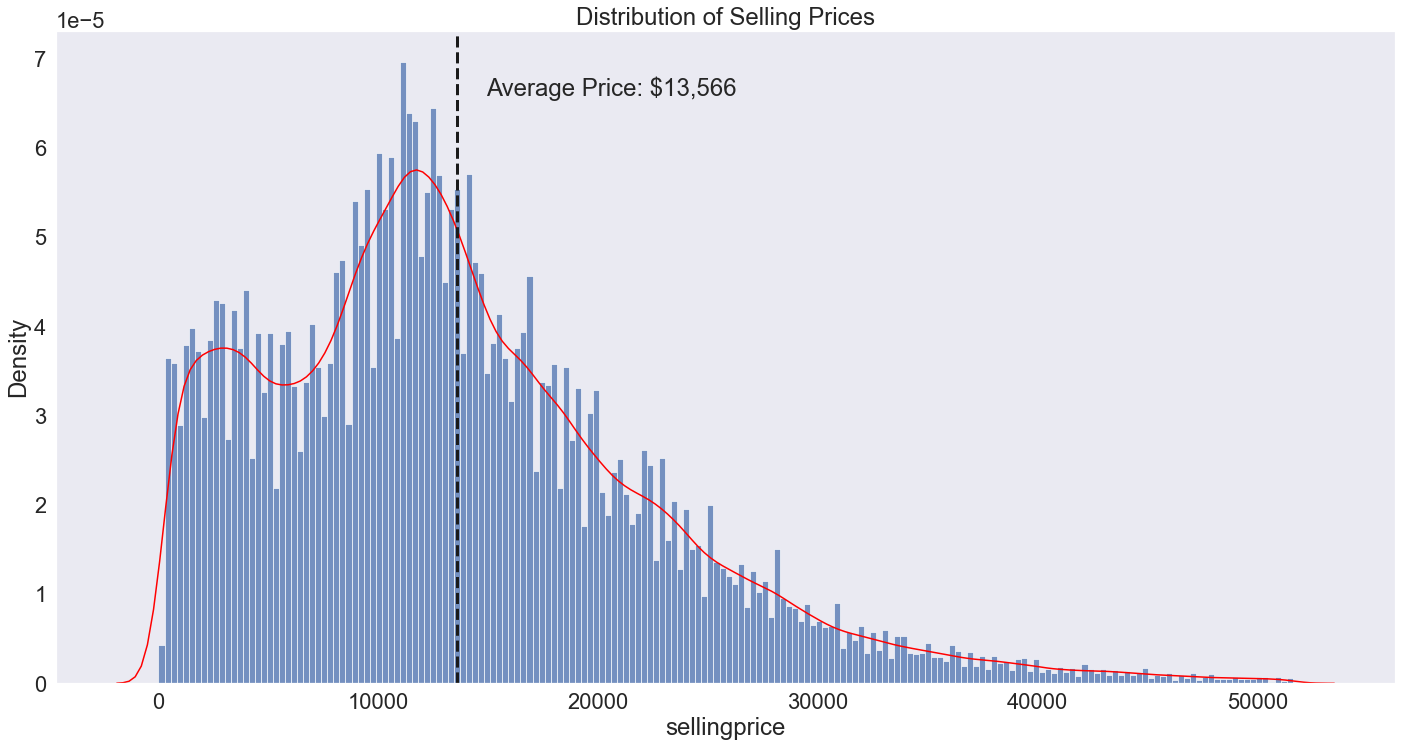

In [11]:
viz.plot_dist(df)

In [12]:
# Split data into Train, validate, test

In [13]:
train, validate, test = wrangle.split_cars(df)

## How good is MMR at predicting sales price?

The Manheim Market Report (MMR) is a valuation guide that provides prices for used automobiles

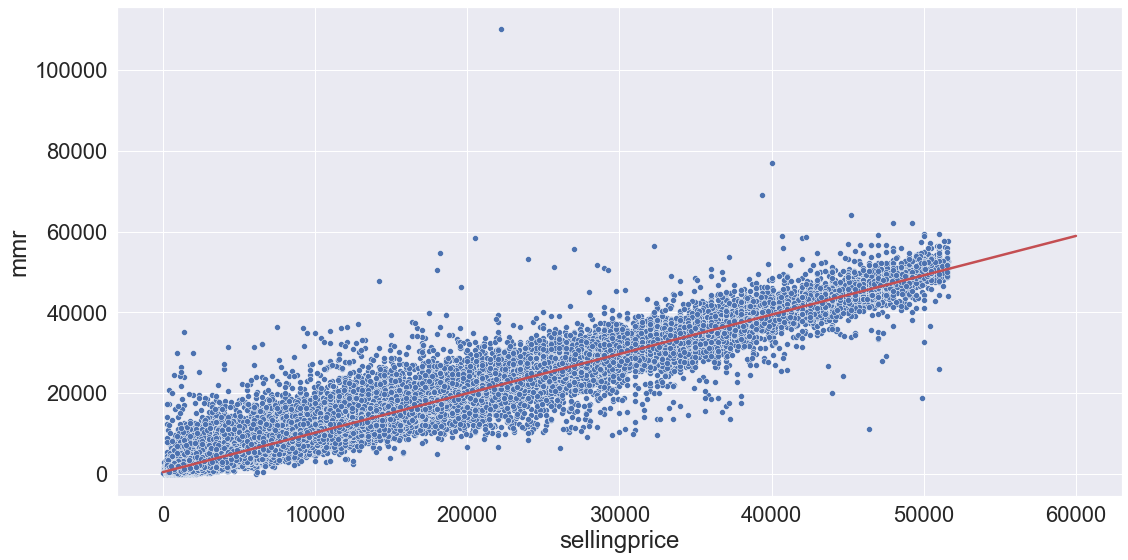

In [14]:
viz.mmr_plot(train)

In [15]:
rmse_mmr = round(mean_squared_error(train.sellingprice, train.mmr, squared=False),2)
r2_mmr = round(r2_score(train.sellingprice, train.mmr),4)
print(f'Baseline RMSE: ${rmse_mmr}, Baseline R2: {r2_mmr}')

Baseline RMSE: $1669.92, Baseline R2: 0.9636


### TODO:  Distribution and Baseline takeaways

In [16]:
## How does transmission affect selling price?

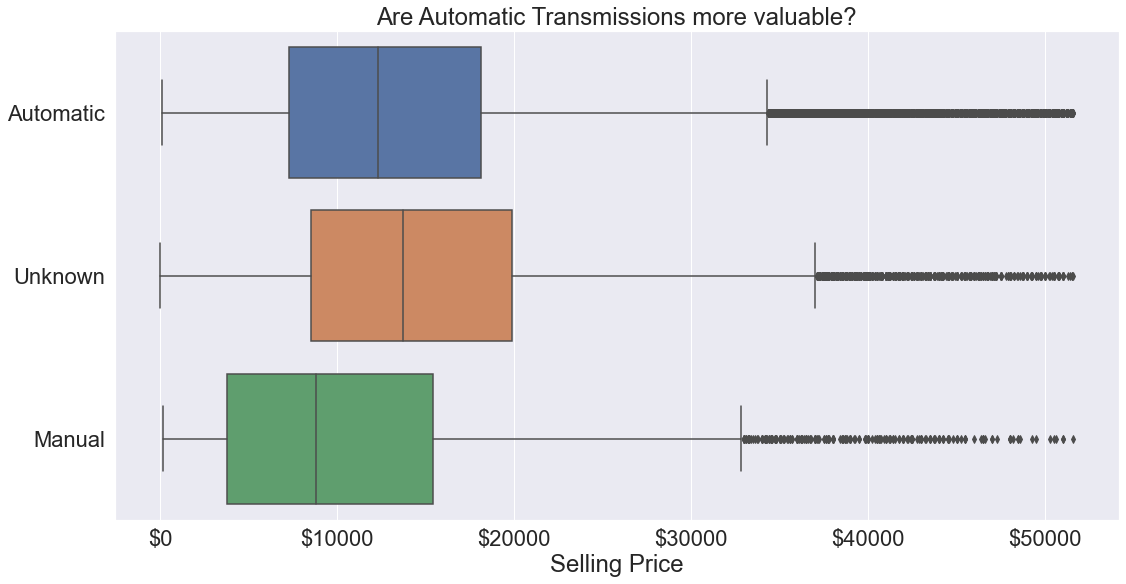

In [17]:
ax = sns.boxplot(data=train, x='sellingprice', y='transmission')
ax.set(title="Are Automatic Transmissions more valuable?",
       yticklabels=['Automatic', 'Unknown', 'Manual'],
       ylabel=None,
       xlabel='Selling Price')
ax.xaxis.set_major_formatter('${x:1.0f}')


plt.show()

- **Hypothesis**

- $H_0$: There is no difference in selling price between the different transmission types

- $H_a$: There is a significant difference in selling price between the different transmission types

In [18]:
# Perform  ANOVA test function from viz.py
viz.transmission_anova(train)

Selling price of automatics:            $13498.51
Selling price of unknown transmissions: $14784.85
Selling price of manuals:               $10831.89

We reject the Null Hypothesis


## What makes are the most and least valuable?

In [19]:
def make_plot(df):
    values = pd.DataFrame(df.groupby('make').sellingprice.mean().sort_values(ascending=False))
    y = values.head().index.tolist() + [' '] + values.tail().index.tolist()
    x = values.head().sellingprice.tolist() + [0] + values.tail().sellingprice.tolist()
    combo = pd.DataFrame()
    combo['Make'] = y
    combo['Selling Price'] = x
    combo['color'] = [1,1,1,1,1,0,0,0,0,0,0]
    combo
    ax = sns.barplot(data=combo, x='Selling Price', y='Make', hue='color')
    plt.title('Five Most and Least Valuable Auto Makes')
    ax.xaxis.set_major_formatter('${x:1.0f}')

    plt.legend([],[], frameon=False)
    plt.show()

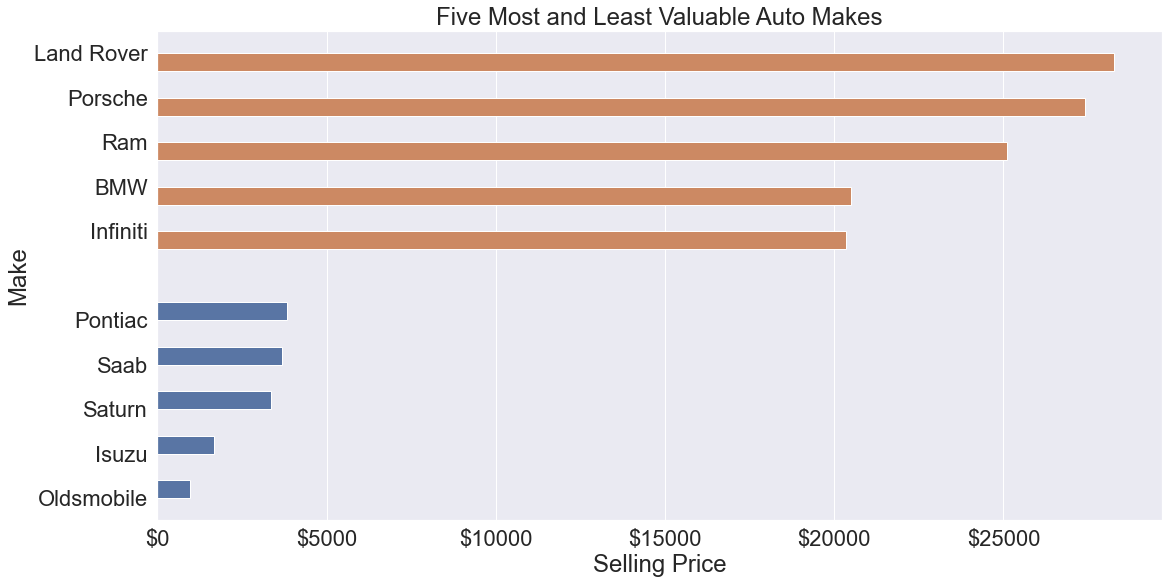

In [20]:
make_plot(train)

## Are year and odometer correlated, and if so how do they effect selling price?

In [21]:
cols = ['year', 'odometer', 'sellingprice']
temp = train[cols].corr()

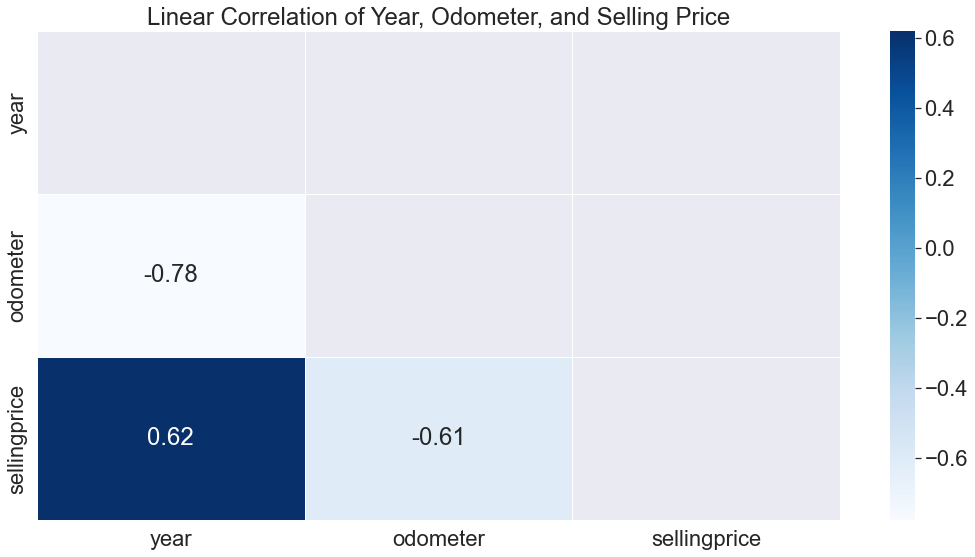

In [22]:
sns.heatmap(temp, cmap='Blues', annot = True, mask= np.triu(temp), linewidth=.5)
plt.title('Linear Correlation of Year, Odometer, and Selling Price')
plt.show()

#### Odometer and Year show relatively strong correlation to Selling Price, but they appear correlated to each other

In [23]:
def correlation_test(df, col_1, col_2):
    r , p = stats.pearsonr(df[col_1], df[col_2])
    
    print(f'H0: {col_1} is not linearly correlated to {col_2}')
    print(f'Ha: {col_1} is linearly correlated to {col_2}')
    print('')
    print ('Correlation coefficient is: {:.3f}'.format(r))
    
    sign = ''      
    if r > 0:
          sign = 'positively'
    else:
          sign = 'negatively'
          
    
    if p > .05:
        print('H0 is confirmed')
    else:
        print(f'H0 is rejected, {col_1} is {sign} correlated to {col_2}')

In [24]:
correlation_test(train, 'odometer', 'year')

H0: odometer is not linearly correlated to year
Ha: odometer is linearly correlated to year

Correlation coefficient is: -0.778
H0 is rejected, odometer is negatively correlated to year


#### By using the date of sale and the year of manufacture we can create age_at_sale.  We can then divide this by the odometer reading to get the miles-per year.  This will let us capture the age and mileage without the colinearlity

In [25]:
train = wrangle.carwash_2(train)
validate = wrangle.carwash_2(validate)
test = wrangle.carwash_2(test)

In [26]:
train.head(1)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,saleyear,age_at_sale,miles_per_year
387777,2010,Chevrolet,Silverado 2500HD,LTZ,truck,automatic,FL,3.8,126386,white,black,18800,20600,2015,5,25277


In [27]:
correlation_test(train, 'miles_per_year', 'year')

H0: miles_per_year is not linearly correlated to year
Ha: miles_per_year is linearly correlated to year

Correlation coefficient is: 0.280
H0 is rejected, miles_per_year is positively correlated to year


In [28]:
correlation_test(train, 'miles_per_year', 'sellingprice')

H0: miles_per_year is not linearly correlated to sellingprice
Ha: miles_per_year is linearly correlated to sellingprice

Correlation coefficient is: -0.019
H0 is rejected, miles_per_year is negatively correlated to sellingprice


### New features Age, and Miles per Year were created to eliminate co-linearlity and better capture the age and condition of the vehicle

## Is condition a driver of selling price?

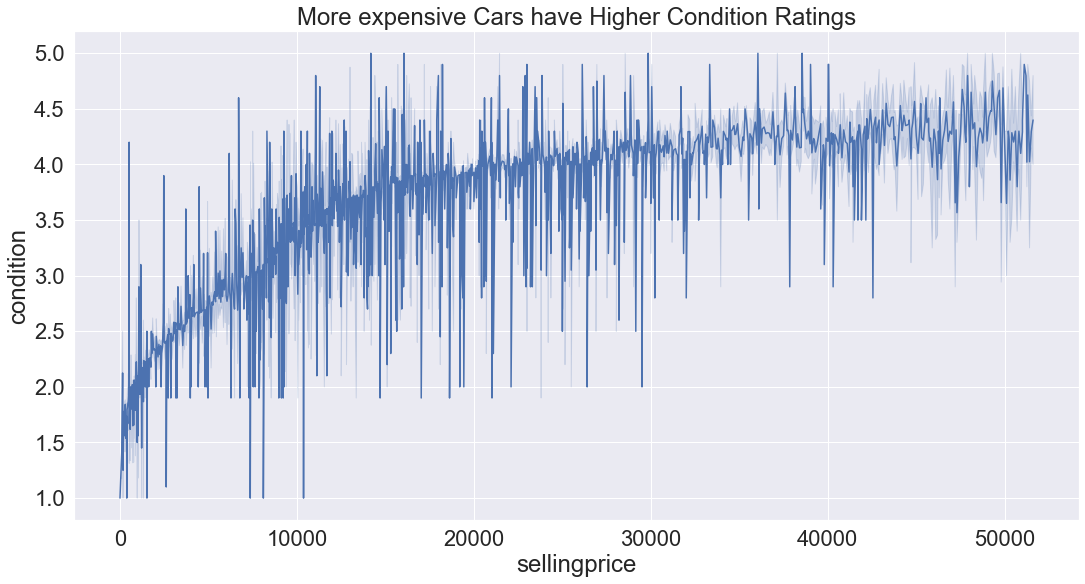

In [29]:
line = sns.lineplot(data=train, x='sellingprice', y='condition')
plt.title('More expensive Cars have Higher Condition Ratings')
plt.show()

In [30]:
correlation_test(train, 'condition', 'sellingprice')

H0: condition is not linearly correlated to sellingprice
Ha: condition is linearly correlated to sellingprice

Correlation coefficient is: 0.563
H0 is rejected, condition is positively correlated to sellingprice


## Explore takeaways

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308328 entries, 387777 to 235796
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            308328 non-null  int64  
 1   make            308328 non-null  object 
 2   model           308328 non-null  object 
 3   trim            308328 non-null  object 
 4   body            308328 non-null  object 
 5   transmission    308328 non-null  object 
 6   state           308328 non-null  object 
 7   condition       308328 non-null  float64
 8   odometer        308328 non-null  int64  
 9   color           308328 non-null  object 
 10  interior        308328 non-null  object 
 11  mmr             308328 non-null  int64  
 12  sellingprice    308328 non-null  int64  
 13  saleyear        308328 non-null  int64  
 14  age_at_sale     308328 non-null  int64  
 15  miles_per_year  308328 non-null  int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 48

## Modelling

Categorical variables will be encoded using TargetScaler, which scales the variable by assigning the mean of the target variable

In [32]:
# encode categorical variables by scaling based upon the mean of the target variable
cats=['trim', 'body', 'make', 'transmission', 'state', 'model', 'color', 'interior']
te = TargetEncoder()
t_values = te.fit_transform(X = train[cats], y = train.sellingprice).add_prefix('enc_')
train = pd.concat([train, t_values], axis = 1)

v_values = te.transform(X = validate[cats], y = validate.sellingprice).add_prefix('enc_')
validate = pd.concat([validate, v_values], axis = 1)

test_values = te.transform(X = test[cats], y = test.sellingprice).add_prefix('enc_')
test = pd.concat([test, test_values], axis = 1)

Verify that columns were transformed as intended

In [72]:
train.iloc[: , -8:-1].head()

,enc_trim,enc_body,enc_make,enc_transmission,enc_state,enc_model,enc_color
387777,18280.555365,17877.614392,11842.323094,13500.149670,13711.878810,20866.449935,14692.905449
444467,30197.990544,15962.564295,28266.643836,14786.343246,15699.569014,26784.209040,15239.380078
147254,11974.069468,11876.962688,11792.225251,13500.149670,15210.565574,11466.132518,14692.905449
20387,9946.176094,17877.614392,14605.312481,14786.343246,13445.988668,7926.469466,13883.011674
498221,9385.785775,11876.962688,11084.366723,13500.149670,13711.878810,7668.734868,11526.116106


In [73]:
# drop original columns
train.drop(columns=cats, inplace=True)
validate.drop(columns=cats, inplace=True)
test.drop(columns=cats, inplace=True)

In [80]:
# create X and y
X_train = train.drop(columns = 'sellingprice')
X_val = validate.drop(columns= 'sellingprice')
X_test = test.drop(columns= 'sellingprice')

y_train = train.sellingprice
y_val = validate.sellingprice
y_test = test.sellingprice

sklearn's Pipeline lets me package a scaler and model into one object, making it easier to work

In [75]:
# build pipeline
pipeline = Pipeline([('scaler', MinMaxScaler()), ('model', xgb.XGBRegressor(eta=.1,
                                                                           gamma=0,
                                                                           min_child_weight=6,
                                                                           max_depth=8))])

In [76]:
# fit model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eta=0.1,
                              eval_metric=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=8, max_leaves=0, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_

In [77]:
# predict train and validation set
yhat_train = pipeline.predict(X_train)
yhat_val = pipeline.predict(X_val)

In [78]:
# evaluate
rmse_train = mean_squared_error(y_train, yhat_train, squared=False)
rmse_val = mean_squared_error(y_val, yhat_val, squared=False)
r2_train = r2_score(y_train, yhat_train)
r2_val = r2_score(y_val, yhat_val)
print(f'In-sample RMSE: {rmse_train}, In-sample r2: {r2_train}')
print(f'Out-of-sample RMSE: {rmse_val}, Out-of-sample r2: {r2_val}')

In-sample RMSE: 1258.0521300107237, In-sample r2: 0.9793616214581332
Out-of-sample RMSE: 1381.2881965458694, Out-of-sample r2: 0.9753619006661532


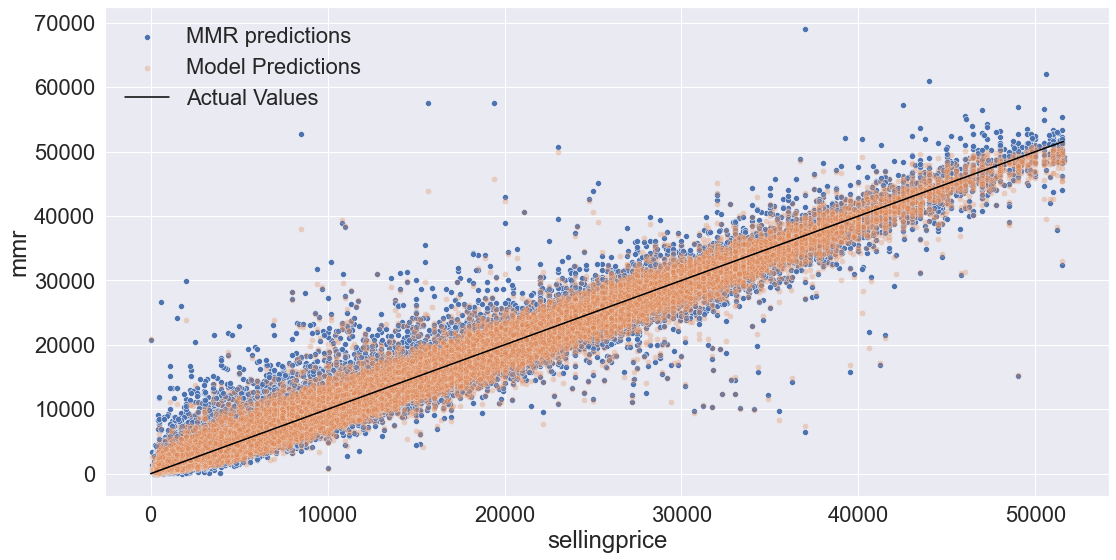

In [79]:
viz.results_plot(validate, yhat_val)